In [438]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mne import read_epochs, compute_rank, EvokedArray
from mne.decoding import CSP
from mne.preprocessing import ICA
from mne.time_frequency import tfr_multitaper
from mne.decoding import UnsupervisedSpatialFilter

from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, ShuffleSplit

from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [2]:
epochs = read_epochs('ica_epo.fif').pick('eeg')
epochs.drop_channels(epochs.info['bads'])

Reading C:\Users\at18157\Desktop\bci\data\ah\ica_epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    7999.02 ms
        0 CTF compensation matrices available
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated


Number of events,74
Events,left: 14r_pinch: 15r_stop: 16rest: 13right: 16
Time range,-2.000 – 7.999 sec
Baseline,off


Get Subset

In [3]:
subset = epochs['left','rest'].copy()
subset.apply_baseline((-1.5,-0.1))
imagery_epochs = subset['left','right'].copy().crop(-0.2,2)
rest_epochs = subset['rest'].copy().crop(-0.2,2)

Applying baseline correction (mode: mean)


PCA

In [401]:
pca = PCA(n_components=0.85)
le = LabelEncoder()

5-20Hz

In [28]:
X_im = imagery_epochs.copy().crop(-0.1,1.5).filter(5,20, n_jobs=4, verbose=False).get_data()
n_eps, n_chan, n_time = X_im.shape
X_im = np.transpose(X_im,(1,0,2)).reshape(n_chan, n_eps*n_time).T

C:\Users\Alberto\AppData\Local\Temp\ipykernel_13308\728237523.py:1: RuntimeWarning: filter_length (1691) is longer than the signal (1639), distortion is likely. Reduce filter length or filter a longer signal.
  X_im = imagery_epochs.copy().crop(-0.1,1.5).filter(5,20, n_jobs=4, verbose=False).get_data()


In [29]:
X_im = pca.fit_transform(X_im)


In [30]:
X_im = X_im.T.reshape((-1, n_eps, n_time)).transpose((1,0,2))

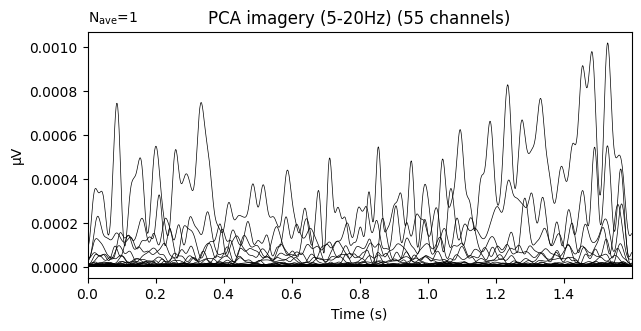

In [31]:
ev = EvokedArray(np.mean(X_im**2, axis=0), imagery_epochs.info)
ev.plot(spatial_colors=False, titles='PCA imagery (5-20Hz)', show=False)
print()

In [32]:
X_rst = rest_epochs.copy().crop(-0.1,1.5).filter(5,20, n_jobs=4, verbose=False).get_data()
n_eps, n_chan, n_time = X_rst.shape
X_rst = np.transpose(X_rst,(1,0,2)).reshape(n_chan, n_eps*n_time).T

C:\Users\Alberto\AppData\Local\Temp\ipykernel_13308\2239228806.py:1: RuntimeWarning: filter_length (1691) is longer than the signal (1639), distortion is likely. Reduce filter length or filter a longer signal.
  X_rst = rest_epochs.copy().crop(-0.1,1.5).filter(5,20, n_jobs=4, verbose=False).get_data()


In [33]:
X_rst = pca.fit_transform(X_rst)
X_rst = X_rst.T.reshape((-1, n_eps, n_time)).transpose((1,0,2)) 

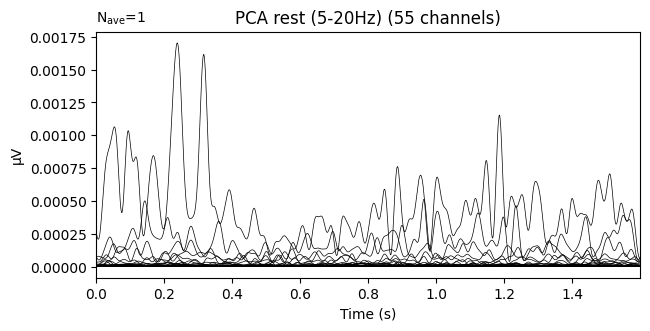

In [34]:
ev = EvokedArray(np.mean(X_rst**2, axis=0), rest_epochs.info)
ev.plot(spatial_colors=False, titles='PCA rest (5-20Hz)')
print()

20-35Hz

In [12]:
X_im = imagery_epochs.copy().crop(-0.1,1.5).filter(20,35, n_jobs=4, verbose=False).get_data()
n_eps, n_chan, n_time = X_im.shape
X_im = np.transpose(X_im,(1,0,2)).reshape(n_chan, n_eps*n_time).T

In [13]:
X_im = pca.fit_transform(X_im)
X_im = X_im.T.reshape((-1, n_eps, n_time)).transpose((1,0,2))

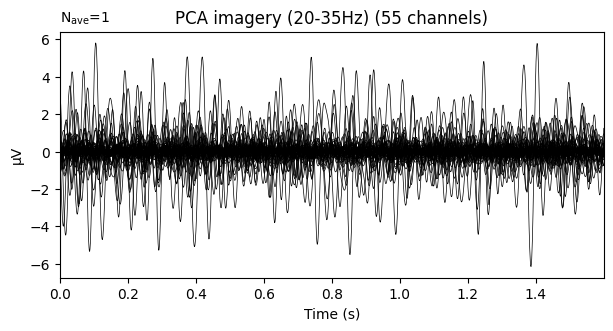

In [14]:
ev = EvokedArray(np.mean(X_im, axis=0), imagery_epochs.info)
ev.plot(spatial_colors=False, titles='PCA imagery (20-35Hz)', show=False)
print()

In [15]:
X_rst = rest_epochs.copy().crop(-0.1,1.5).filter(20,35, n_jobs=4, verbose=False).get_data()
n_eps, n_chan, n_time = X_rst.shape
X_rst = np.transpose(X_rst,(1,0,2)).reshape(n_chan, n_eps*n_time).T

In [16]:
X_rst = pca.fit_transform(X_rst)
X_rst = X_rst.T.reshape((-1, n_eps, n_time)).transpose((1,0,2)) 

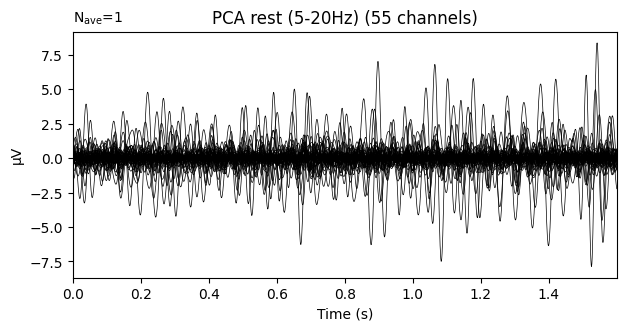

In [17]:
ev = EvokedArray(np.mean(X_rst, axis=0), rest_epochs.info)
ev.plot(spatial_colors=False, titles='PCA rest (5-20Hz)')
print()

70-90Hz

In [18]:
X_im = imagery_epochs.copy().crop(-0.1,1.5).filter(70,90, n_jobs=4, verbose=False).get_data()
n_eps, n_chan, n_time = X_im.shape
X_im = np.transpose(X_im,(1,0,2)).reshape(n_chan, n_eps*n_time).T

In [19]:
X_im = pca.fit_transform(X_im)
X_im = X_im.T.reshape((-1, n_eps, n_time)).transpose((1,0,2))

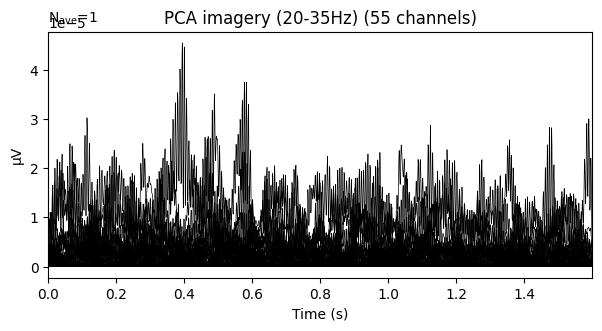

In [27]:
ev = EvokedArray(np.mean(X_im**2, axis=0), imagery_epochs.info)
ev.plot(spatial_colors=False, titles='PCA imagery (20-35Hz)', show=False)
print()

In [23]:
X_rst = rest_epochs.copy().crop(-0.1,1.5).filter(70,90, n_jobs=4, verbose=False).get_data()
n_eps, n_chan, n_time = X_rst.shape
X_rst = np.transpose(X_rst,(1,0,2)).reshape(n_chan, n_eps*n_time).T

In [24]:
X_rst = pca.fit_transform(X_rst)
X_rst = X_rst.T.reshape((-1, n_eps, n_time)).transpose((1,0,2)) 

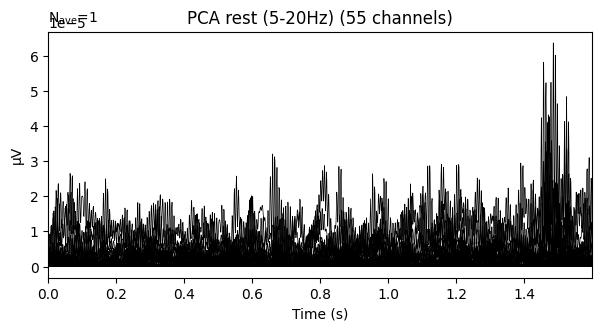

In [26]:
ev = EvokedArray(np.mean(X_rst**2, axis=0), rest_epochs.info)
ev.plot(spatial_colors=False, titles='PCA rest (5-20Hz)')
print()

Temporal Features

In [420]:
X = subset.copy().crop(0,0.8).filter(18,30, n_jobs=4, verbose=False)
y = le.fit_transform(X.events[:,2])

In [421]:
X = X.get_data()
n_eps, n_chan, n_time = X.shape
X = np.transpose(X,(1,0,2)).reshape(n_chan, n_eps*n_time).T
X.shape

(22140, 55)

In [422]:
X = pca.fit_transform(X)

<AxesSubplot: >

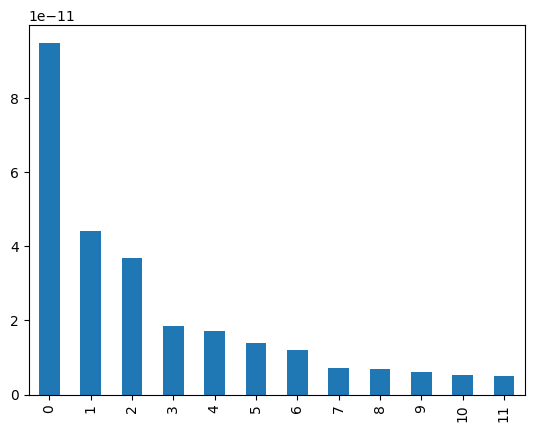

In [423]:
pd.DataFrame(X).var().plot.bar()

In [424]:
X = X.T.reshape((-1, n_eps, n_time)).transpose((1,0,2))
X.shape

(27, 12, 820)

In [425]:
X_power = X**2

In [426]:
def avg(x): 
    return np.average(x)

def autocorr(x):
    return float(np.correlate(x,x))
    
def temp_centroid(x):
    nom = [x[i] * i for i in range(x.shape[0])]
    return sum(nom)/sum(x)

def mean_abs_diff(x):
    return np.mean(np.abs(np.diff(x)))

def median_abs_diff(x):
    return np.median(np.abs(np.diff(x)))

def slope(x):
    t = np.linspace(0, len(x)-1, len(x))
    return np.polyfit(t, x, 1)[0]
    
def entropy(x):
    max_a = max(x) if max(x) > 0 else -max(x)
    min_a = min(x)
    ampl = np.linspace(min_a, max_a, len(x))
    kernel = gaussian_kde(x, bw_method='silverman')
    p = np.array(kernel(x) / np.sum(kernel(x)))
    
    if np.sum(p) == 0:
        return 0.0
    p = p[np.where(p != 0)]
    
    if np.log2(len(x)) == 1:
        return 0.0
    
    ent = np.sum(p*np.log2(p)) / np.log2(len(x))
    if ent == 0:
        return 0.0
    return -ent 



In [427]:
#Average power
X_avg = np.apply_along_axis(avg, 2, X_power)
X_avg.shape

(27, 12)

In [428]:
#Autocorrelation
X_autoc = np.apply_along_axis(autocorr, 2, X)
X_autoc.shape

(27, 12)

In [429]:
#Temporal centroid
X_centr = np.apply_along_axis(temp_centroid, 2, X_power)
X_centr.shape

(27, 12)

In [430]:
#Mean absolute difference
X_mean_abs_dff = np.apply_along_axis(mean_abs_diff, 2, X)
X_mean_abs_dff.shape

(27, 12)

In [431]:
#Median absolute difference
X_median_abs_dff = np.apply_along_axis(median_abs_diff, 2, X)
X_median_abs_dff.shape

(27, 12)

In [432]:
#Slope
X_slope = np.apply_along_axis(slope, 2, X)
X_slope.shape

(27, 12)

In [433]:
#Entropy with Kernel estimator
X_ent = np.apply_along_axis(entropy, 2, X)
X_ent.shape

(27, 12)

Classification

In [434]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=34)
lda = LinearDiscriminantAnalysis()

In [435]:
scores_avg = cross_val_score(lda, X_avg, y, scoring='accuracy', cv=cv, n_jobs=4)
scores_autoc = cross_val_score(lda, X_autoc, y, scoring='accuracy', cv=cv, n_jobs=4)
scores_centr = cross_val_score(lda, X_centr, y, scoring='accuracy', cv=cv, n_jobs=4)
scores_mean_dff = cross_val_score(lda, X_mean_abs_dff, y, scoring='accuracy', cv=cv, n_jobs=4)
scores_median_dff = cross_val_score(lda, X_median_abs_dff, y, scoring='accuracy', cv=cv, n_jobs=4)
scores_slope = cross_val_score(lda, X_mean_abs_dff, y, scoring='accuracy', cv=cv, n_jobs=4)
scores_ent = cross_val_score(lda, X_ent, y, scoring='accuracy', cv=cv, n_jobs=4)


In [436]:
scores = [scores_avg, scores_autoc, scores_centr, scores_mean_dff, scores_median_dff, scores_slope, scores_ent]
scores_df = pd.DataFrame(data=np.transpose(scores), columns=['avg pwr', 'autocorr', 'centroid', 'mean abs dff', 'med abs dff', 'slope', 'entropy'])

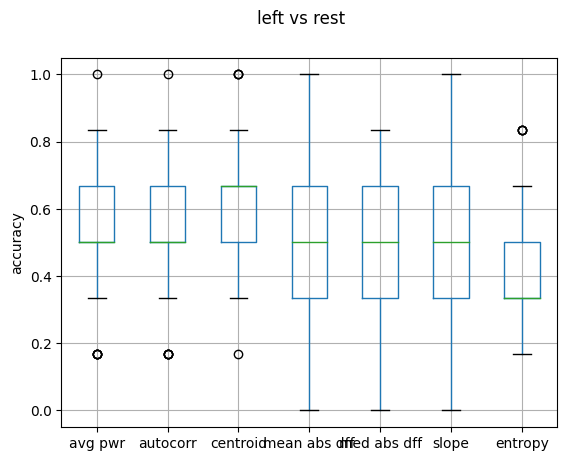

In [437]:
csp_fig, axes = plt.subplots(1)
scores_df.boxplot(ax=axes)
axes.set_ylabel('accuracy')
csp_fig.suptitle('left vs rest')
plt.show()